# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [ ]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

In [ ]:
import numpy as np
from clearml import Logger
from typing import List

In [ ]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Dataset loading


In [ ]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2024-12-11 14:28:43--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.164.96, 52.216.107.134, 54.231.231.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.164.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10.96M  17.5MB/s    in 0.6s    

2024-12-11 14:28:44 (17.5 MB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [ ]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
### Your code goes here ###

from clearml import Task

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = ''#@param {type:"string"}
secret_key = ''#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

###########################

# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [ ]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [ ]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> List[float]:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        losses = [wloss]
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            losses.append(wloss)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))

        return losses


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=10,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.7908, Loss: 1.293872708645061
Epoch: 1, Accuracy: 0.8641, Loss: 0.6259298012996074
Epoch: 2, Accuracy: 0.8845, Loss: 0.4972863901227483
Epoch: 3, Accuracy: 0.8957, Loss: 0.4375487936706163
Epoch: 4, Accuracy: 0.9035, Loss: 0.3995818978279905
Epoch: 5, Accuracy: 0.9093, Loss: 0.3727130400858498
Epoch: 6, Accuracy: 0.9119, Loss: 0.3521971317225474
Epoch: 7, Accuracy: 0.9149, Loss: 0.33553237189756424
Epoch: 8, Accuracy: 0.9177, Loss: 0.32169432861389374
Epoch: 9, Accuracy: 0.9219, Loss: 0.3099571742785099


[12.233600734538879,
 1.293872708645061,
 0.6259298012996074,
 0.4972863901227483,
 0.4375487936706163,
 0.3995818978279905,
 0.3727130400858498,
 0.3521971317225474,
 0.33553237189756424,
 0.32169432861389374,
 0.3099571742785099]

# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 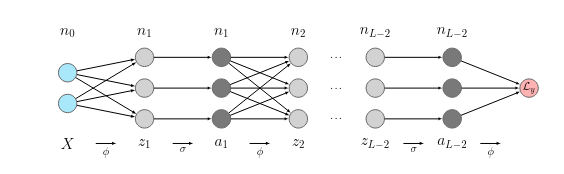)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 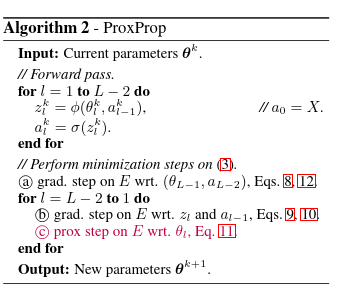)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 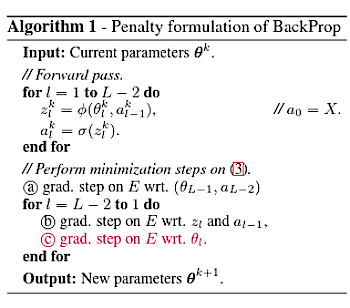)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

In [ ]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]


    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(w @ a + b)
        return a

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        fs = []
        g = x
        gs = [g]
        for w, b in zip(self.weights, self.biases):
            f = w @ g + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)

        loss = logloss(gs[-1], y)
        new_biases = []
        new_weights = []
        dLdg = self.cost_derivative(gs[-1], y)
        g_star = gs[-1] - eta * dLdg
        dLdf = dLdg * gs[-1] * (1 - gs[-1])
        f_diff = gs[-1] * (1 - gs[-1]) * (gs[-1] - g_star)
        for f, g, b, w in reversed(list(zip(fs, gs[:-1], self.biases, self.weights))):
            f_star = f - f_diff
            new_biases.append(b - (eta / len(y[0])) * np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1))
            new_weights.append(((f_star - new_biases[-1]) @ g.T + (1 / eta) * w) @ np.linalg.inv(g @ g.T + (1 / eta) * np.identity(len(g))))
            dLdg = w.T @ dLdf
            g_star = g - w.T @ (f - f_star)
            dLdf = dLdg * g * (1 - g)
            f_diff = g * (1 - g) * (g - g_star)

        self.biases = [b for b in reversed(new_biases)]
        self.weights = [w for w in reversed(new_weights)]

        return loss

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> List[float]:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        losses = [wloss]
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )  # we compute the average of the losses over the number of minibatches
            losses.append(wloss)

        return losses



# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0925, Loss: 10.440993181963227
Epoch: 1, Accuracy: 0.8601, Loss: 0.7838068477744375
Epoch: 2, Accuracy: 0.8989, Loss: 0.4333312396185057


[10.440993181963227, 0.7838068477744375, 0.4333312396185057]

# Train the network

In [ ]:
### Your code goes here ###

# both networks training with the same weights
# proxprop consistently gets 94% accuracy

prox_network = ProxProp([784, 80, 80, 10])
simple_network = Network([784, 80, 80, 10])
simple_network.biases = [b for b in prox_network.biases]
simple_network.weights = [w for w in prox_network.weights]
losses_simple = simple_network.SGD(
    (x_train, y_train),
    epochs=10,
    mini_batch_size=100,
    eta=10.0,
    test_data=(x_test, y_test),
)
losses_prox = prox_network.SGD(
    (x_train, y_train),
    epochs=10,
    mini_batch_size=100,
    eta=10.0,
    test_data=(x_test, y_test),
)

###########################

Epoch: 0, Accuracy: 0.5589, Loss: 9.874324818337815
Epoch: 1, Accuracy: 0.5834, Loss: 6.7963955722994625
Epoch: 2, Accuracy: 0.659, Loss: 5.680605741069551
Epoch: 3, Accuracy: 0.6664, Loss: 5.353442282366305
Epoch: 4, Accuracy: 0.6711, Loss: 5.249602185747484
Epoch: 5, Accuracy: 0.6719, Loss: 5.165845328955746
Epoch: 6, Accuracy: 0.6742, Loss: 5.100912169826264
Epoch: 7, Accuracy: 0.6787, Loss: 5.016809952283032
Epoch: 8, Accuracy: 0.7588, Loss: 3.991524165691484
Epoch: 9, Accuracy: 0.7624, Loss: 3.814906269847767
Epoch: 0, Accuracy: 0.0984, Loss: 41.37642210668409
Epoch: 1, Accuracy: 0.896, Loss: 1.3123503047320069
Epoch: 2, Accuracy: 0.9172, Loss: 0.5621524653307737
Epoch: 3, Accuracy: 0.9275, Loss: 0.4790511809118587
Epoch: 4, Accuracy: 0.9315, Loss: 0.4354187505305357
Epoch: 5, Accuracy: 0.9357, Loss: 0.40497778942629475
Epoch: 6, Accuracy: 0.9383, Loss: 0.38640042183250656
Epoch: 7, Accuracy: 0.9376, Loss: 0.3722677216899133
Epoch: 8, Accuracy: 0.9376, Loss: 0.3470734448584457
Epo

# Training plots for the best training

ClearML Task: created new task id=6f8235cc99a34a80a735bc0e7da0361d
2024-12-11 14:59:38,933 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/6988c45201f8482082e4086b16e8533a/experiments/6f8235cc99a34a80a735bc0e7da0361d/output/log


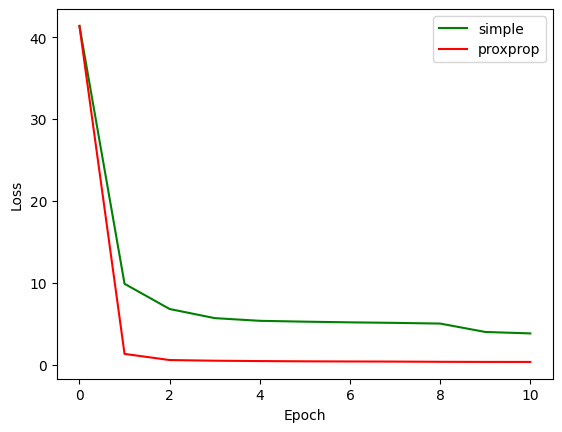

ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [ ]:
### Your code goes here ###

import matplotlib.pyplot as plt

task = Task.init(project_name='Homework1', task_name='proxprop_comparison')

plt.plot(losses_simple, color='g', label='simple')
plt.plot(losses_prox, color='r', label='proxprop')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

task.close()

###########################

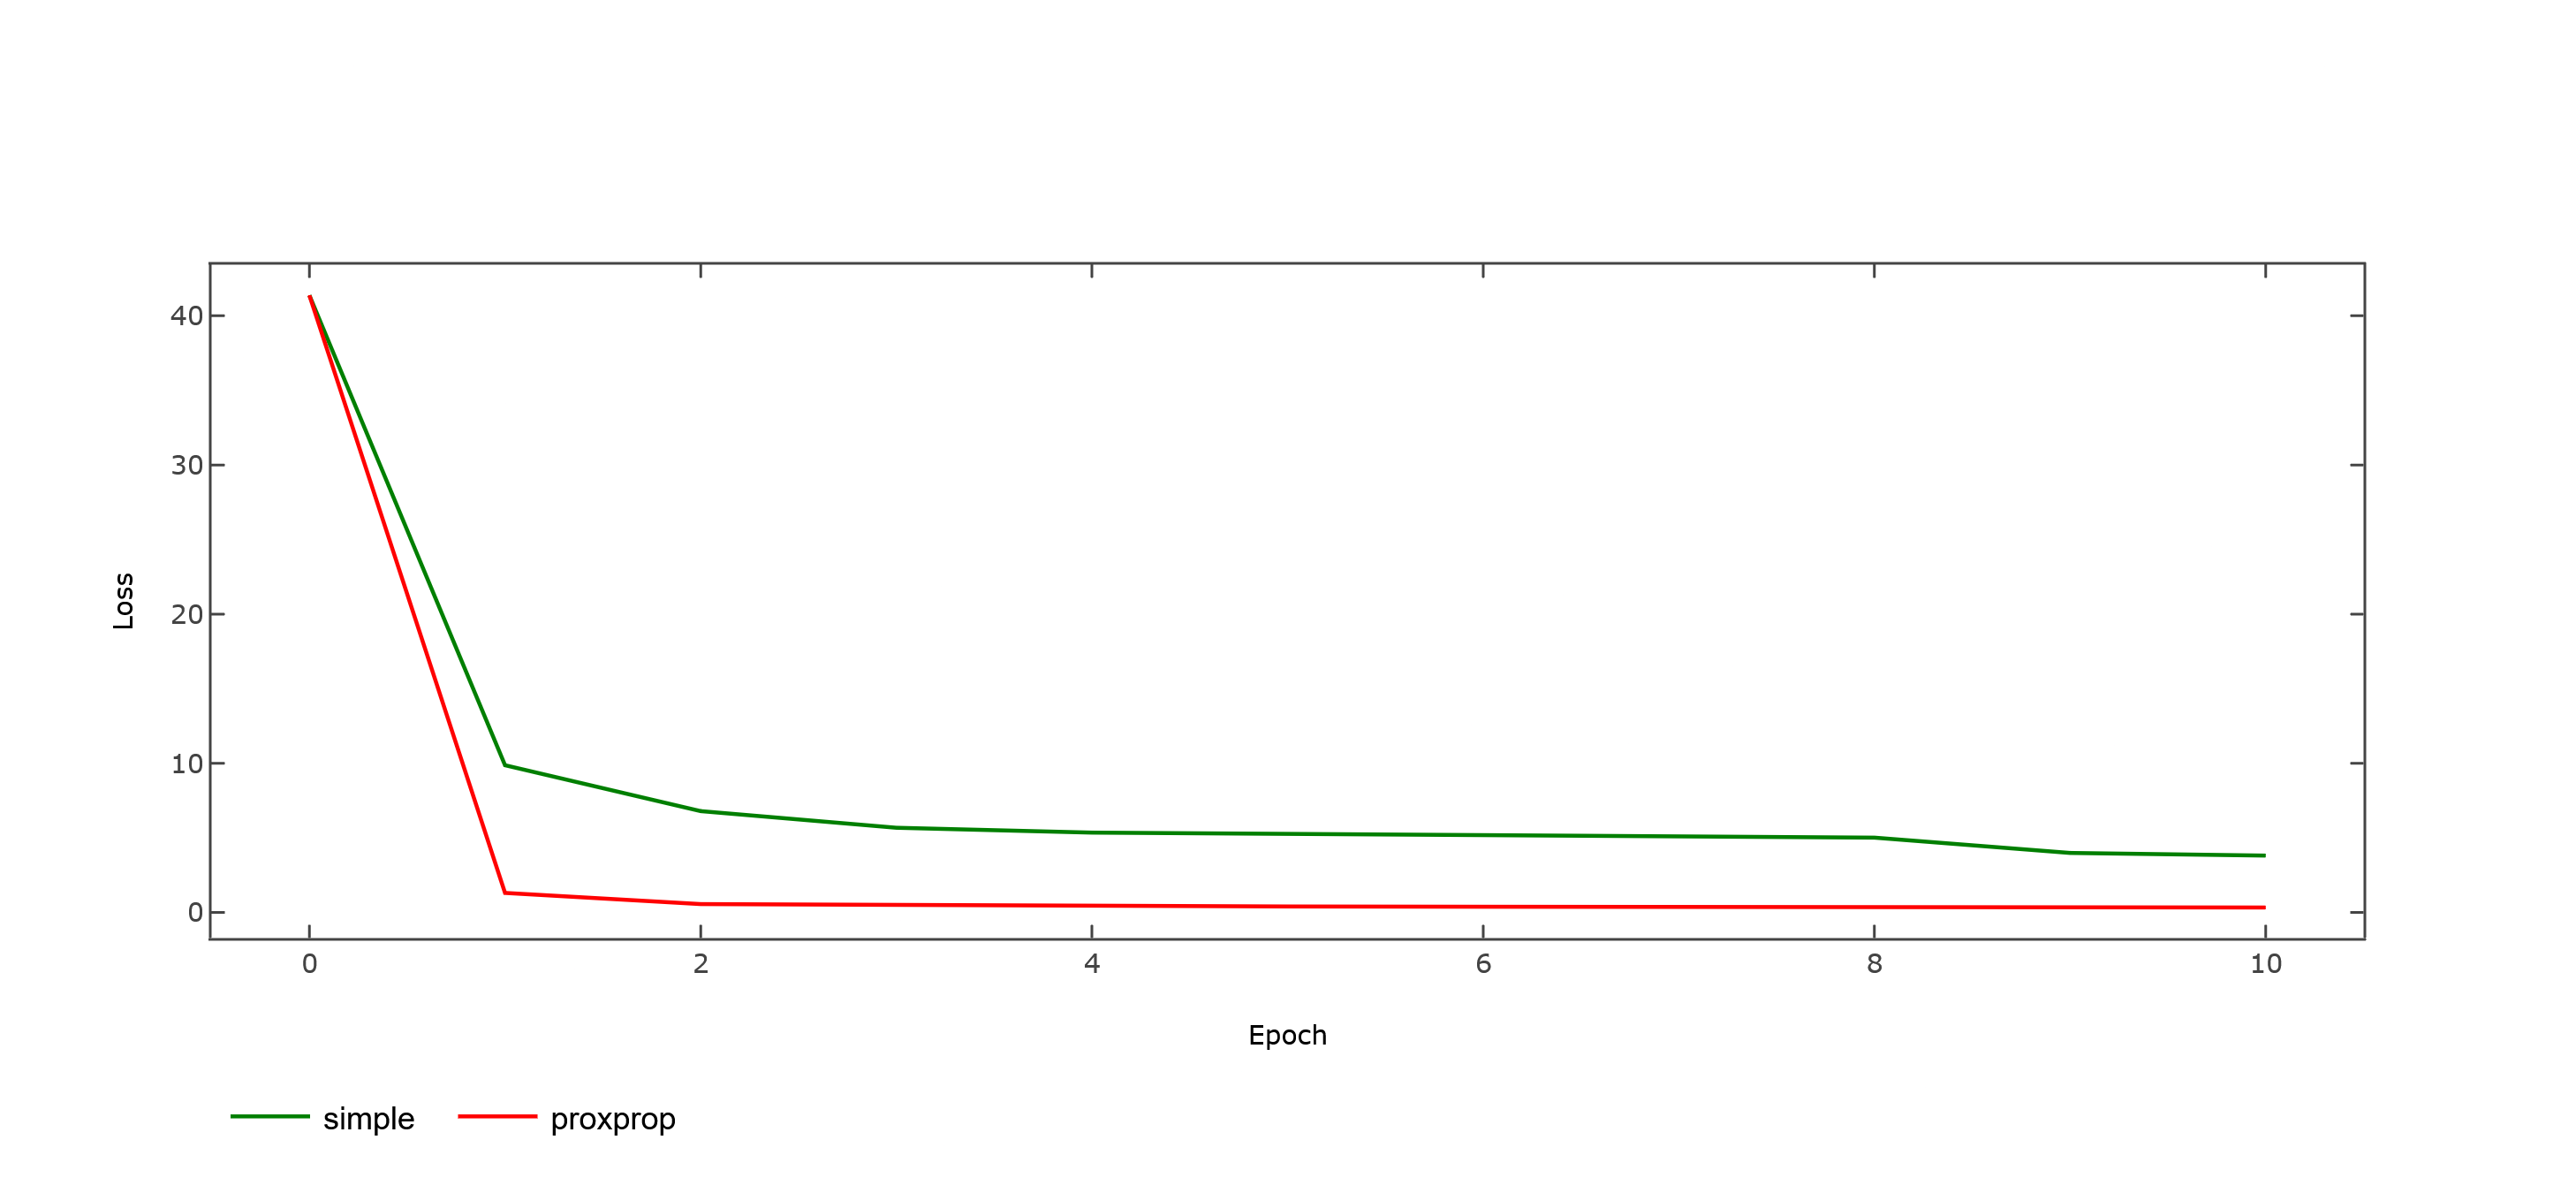

In [ ]:
# displaying downloaded plot picture

from IPython.display import Image

Image('experiment_plot.png')

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [ ]:
### Your code goes here ###

from memory_profiler import memory_usage

simple_network = Network([784, 80, 80, 10])
prox_network = ProxProp([784, 80, 80, 10])

mem_usage_simple = memory_usage((
    simple_network.SGD,
    ((x_train, y_train),),
    {'epochs' : 5, 'mini_batch_size' : 100, 'eta' : 10.0, 'test_data' : (x_test, y_test)}
))

mem_usage_prox = memory_usage((
    prox_network.SGD,
    ((x_train, y_train),),
    {'epochs' : 5, 'mini_batch_size' : 100, 'eta' : 10.0, 'test_data' : (x_test, y_test)}
))

print(mem_usage_simple)
print(mem_usage_prox)

# proxprop uses similar amount of memory per timestamp but takes longer to compute

###########################

Epoch: 0, Accuracy: 0.2899, Loss: 10.373271191595784
Epoch: 1, Accuracy: 0.3122, Loss: 9.919241203908623
Epoch: 2, Accuracy: 0.3852, Loss: 8.654344536550465
Epoch: 3, Accuracy: 0.4734, Loss: 7.233880392203459
Epoch: 4, Accuracy: 0.6088, Loss: 5.82300209487635
Epoch: 0, Accuracy: 0.1128, Loss: 18.032266815473758
Epoch: 1, Accuracy: 0.9044, Loss: 0.7746411709720352
Epoch: 2, Accuracy: 0.9253, Loss: 0.4944581378177237
Epoch: 3, Accuracy: 0.9331, Loss: 0.43126919493976934
Epoch: 4, Accuracy: 0.9373, Loss: 0.3792348139833949
Epoch: 5, Accuracy: 0.9369, Loss: 0.36313082486226167
[1594.21484375, 1594.34765625, 1630.828125, 1630.83203125, 1630.83203125, 1685.578125, 1667.0859375, 1734.73828125, 1594.2109375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.21484375, 1594.